Klasifikasi Text Mining menggunakan Naive Bayes

In [1]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # istilah-istilah yang akan dinormalisasi (misalnya, email, persen, uang, dll)
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    
    # istilah-istilah yang akan diberi anotasi (misalnya, hashtag, huruf kapital semua, pengulangan, dll)
    # annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'},
    
    fix_html=True,  # memperbaiki token HTML
    
    # korpus yang akan digunakan untuk statistik kata, 
    # untuk pemisahan kata (word segmentation)
    segmenter="twitter", 
    
    # korpus yang digunakan untuk statistik kata, digunakan untuk koreksi ejaan
    corrector="twitter", 
    
    unpack_hashtags=True,  # melakukan pemisahan kata pada hashtag
    unpack_contractions=True,  # menguraikan kontraksi (contohnya "can't" menjadi "can not")
    spell_correct_elong=False,  # koreksi ejaan untuk kata yang diperpanjang (contohnya "loooove" menjadi "love")
    
    # memilih tokenizer. SocialTokenizer digunakan di sini, atau bisa memberikan tokenizer lain
    # tokenizer ini akan menerima input berupa string dan mengembalikan daftar token (kata)
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # daftar kamus, untuk mengganti token yang diambil dari teks dengan ekspresi lain, bisa memberikan lebih dari satu kamus
    dicts=[emoticons]
)

C:\Users\annis\AppData\Local\Programs\Python\Python312\Lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


C:\Users\annis\AppData\Local\Programs\Python\Python312\Lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [2]:
import re
import string 
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [3]:
df = pd.read_csv('Dataset_Sentimen_Emosi.csv')

In [4]:
df.head()

,Tweet,Sentimen,Emosi
0,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,1
1,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,-1
2,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,1
3,Covid belum nyampe prigen mbak hmm hoax,0.0,-2
4,"Nyuruh orang pintar, lu aja Togog. Itu kerumun...",-1.0,-2


In [5]:
df = df.drop(['Emosi'], axis=1)

In [6]:
df.head()

,Tweet,Sentimen
0,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0
1,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0
2,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0
3,Covid belum nyampe prigen mbak hmm hoax,0.0
4,"Nyuruh orang pintar, lu aja Togog. Itu kerumun...",-1.0


In [7]:
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    # Semua spasi berturut-turut akan diganti dengan satu spasi
    return " ".join(text.split())

def remove_emoji_alzami(text):
    # Fungsi ini menghapus emotikon atau teks yang dimulai dengan simbol "#" atau "@" 
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    # Fungsi ini menghapus tab, newline, dan karakter khusus lainnya yang diwakili dengan simbol '\\'
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    # Fungsi ini menghapus teks 'RT' (biasanya digunakan di Twitter untuk menandakan retweet)
    return text.replace('RT'," ")

def remove_mention(text):
    # Fungsi ini menghapus mention dan URL
    # Menyaring teks yang diawali dengan '@' atau '#' dan URL yang dimulai dengan 'http://'
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    # Fungsi ini menghapus link yang dimulai dengan 'http://' atau 'https://'
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    # Fungsi ini menghapus karakter tunggal (seperti huruf atau angka satu karakter)
    # Fungsi ini menggunakan regex untuk mencari kata yang hanya terdiri dari satu karakter
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    # Fungsi ini mengganti karakter stripe '-' dengan spasi
    return text.replace('-'," ")

def lower(text):
    # Fungsi ini mengubah seluruh teks menjadi huruf kecil
    return text.lower()

def remove_punctuation(text):
    # Fungsi ini menghapus tanda baca dari teks
    # Tanda baca yang tidak ingin dihapus adalah garis hubung (hyphen '-')
    remove = string.punctuation
    remove = remove.replace("_", "") # jangan hapus tanda hubung
    pattern = r"[{}]".format(remove) # membuat pola regex untuk mencocokkan tanda baca
    return re.sub(pattern, "", text)

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\w'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\w'
C:\Users\annis\AppData\Local\Temp\ipykernel_20668\3936891117.py:20: SyntaxWarning: invalid escape sequence '\s'
  return re.sub('\s+',' ',text)
C:\Users\annis\AppData\Local\Temp\ipykernel_20668\3936891117.py:29: SyntaxWarning: invalid escape sequence '\w'
  return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())


In [8]:
final_string = []
for text in df['Tweet'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc) 
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

In [9]:
df["step01"] = final_string

In [10]:
df.head(1)

,Tweet,Sentimen,step01
0,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...


cek jumlah dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tweet     904 non-null    object 
 1   Sentimen  903 non-null    float64
 2   step01    904 non-null    object 
dtypes: float64(1), object(2)
memory usage: 21.3+ KB


## hapus record yang kosong

In [12]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [13]:
df_new = df[~df.isin(df_hapus)].dropna()

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 902 entries, 0 to 903
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tweet     902 non-null    object 
 1   Sentimen  902 non-null    float64
 2   step01    902 non-null    object 
dtypes: float64(1), object(2)
memory usage: 28.2+ KB


## normalisasi kata slang

In [15]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\annis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [17]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [18]:
df_new.head(10)

,Tweet,Sentimen,step01,tokens
0,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit..."
1,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu..."
2,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga..."
3,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]"
4,"Nyuruh orang pintar, lu aja Togog. Itu kerumun...",-1.0,nyuruh orang pintar lu aja togog itu kerumunan...,"[nyuruh, orang, pintar, lu, aja, togog, itu, k..."
5,Pikir2 balik byk mnde plk nk setelkn lepas covid.,0.0,pikir2 balik byk mnde plk nk setelkn lepas covid,"[pikir2, balik, byk, mnde, plk, nk, setelkn, l..."
6,"Selamat pagi, hari jum'at. Jum'at keempat di k...",1.0,selamat pagi hari jum at jum at keempat di kal...,"[selamat, pagi, hari, jum, at, jum, at, keempa..."
7,"Hikmah di balik musibah covid-19, smg para pej...",1.0,hikmah di balik musibah covid number smg para ...,"[hikmah, di, balik, musibah, covid, number, sm..."
8,Cegah covid-19 beserta jajaran Polsek Kuranji ...,1.0,cegah covid number beserta jajaran polsek kura...,"[cegah, covid, number, beserta, jajaran, polse..."
9,Ya Allah kami memohon pada mu perkenankanlah d...,1.0,ya allah kami memohon pada mu perkenankanlah d...,"[ya, allah, kami, memohon, pada, mu, perkenank..."


In [20]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
normalized_word = pd.read_excel("kamus perbaikan kata.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

C:\Users\annis\AppData\Local\Temp\ipykernel_20668\3176908213.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalized_word_dict:
C:\Users\annis\AppData\Local\Temp\ipykernel_20668\3176908213.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized_word_dict[row[0]] = row[1]


In [22]:
df_new.head()

,Tweet,Sentimen,step01,tokens,tokens_perbaikan
0,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, kit..."
1,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu...","[aku, mohon, yaallah, semoga, wabah, covid, nu..."
2,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, jadi, tangga..."
3,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]","[covid, belum, nyampe, prigen, mbak, aduh, boh..."
4,"Nyuruh orang pintar, lu aja Togog. Itu kerumun...",-1.0,nyuruh orang pintar lu aja togog itu kerumunan...,"[nyuruh, orang, pintar, lu, aja, togog, itu, k...","[nyuruh, orang, pintar, kamu, saja, togog, itu..."


In [23]:
df_new.iloc[0].tokens

['cegah',
 'mata',
 'rantai',
 'covid',
 'number',
 'mari',
 'kita',
 'dirumah',
 'saja',
 'hingga',
 'hari',
 'minggu',
 'repeated']

In [24]:
df_new.iloc[0].tokens_perbaikan

['cegah',
 'mata',
 'rantai',
 'covid',
 'number',
 'mari',
 'kita',
 'dirumah',
 'saja',
 'hingga',
 'hari',
 'minggu',
 'repeated']

In [25]:
# Stopword Menggunakan Modul NLTK
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Tweet,Sentimen,step01,tokens,tokens_perbaikan,Stop_removal
0,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, dir..."
1,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu...","[aku, mohon, yaallah, semoga, wabah, covid, nu...","[mohon, yaallah, semoga, wabah, covid, number,..."
2,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, tanggap, dar..."
3,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]","[covid, belum, nyampe, prigen, mbak, aduh, boh...","[covid, nyampe, prigen, mbak, aduh, bohong]"
4,"Nyuruh orang pintar, lu aja Togog. Itu kerumun...",-1.0,nyuruh orang pintar lu aja togog itu kerumunan...,"[nyuruh, orang, pintar, lu, aja, togog, itu, k...","[nyuruh, orang, pintar, kamu, saja, togog, itu...","[nyuruh, orang, pintar, togog, kerumunan, oran..."
...,...,...,...,...,...,...
899,Seluruh negara di dunia mengalami masa sulit k...,1.0,seluruh negara di dunia mengalami masa sulit k...,"[seluruh, negara, di, dunia, mengalami, masa, ...","[seluruh, negara, di, dunia, mengalami, masa, ...","[negara, dunia, mengalami, sulit, covid, numbe..."
900,"Setelah covid dan skripsi disaster selesai, ma...",1.0,setelah covid dan skripsi disaster selesai mau...,"[setelah, covid, dan, skripsi, disaster, seles...","[setelah, covid, dan, skripsi, disaster, seles...","[covid, skripsi, disaster, selesai, banget, be..."
901,"Malam ini!! Projek ""BENDA BOLEH BINCANG"" 9 mal...",0.0,malam ini repeated projek allcaps benda boleh ...,"[malam, ini, repeated, projek, allcaps, benda,...","[malam, ini, repeated, proyek, allcaps, benda,...","[malam, repeated, proyek, allcaps, benda, binc..."
902,Pontang - panting di koyak covid 19,-1.0,pontang panting di koyak covid number,"[pontang, panting, di, koyak, covid, number]","[pontang, panting, di, koyak, covid, number]","[pontang, panting, koyak, covid, number]"


In [27]:
df_new.iloc[0].tokens_perbaikan

['cegah',
 'mata',
 'rantai',
 'covid',
 'number',
 'mari',
 'kita',
 'dirumah',
 'saja',
 'hingga',
 'hari',
 'minggu',
 'repeated']

In [28]:
df_new.iloc[0].Stop_removal

['cegah',
 'mata',
 'rantai',
 'covid',
 'number',
 'mari',
 'dirumah',
 'minggu',
 'repeated']

In [29]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [30]:
df_new["step02"] = final_string_tokens

In [31]:
df_new.head()

,Tweet,Sentimen,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, dir...",cegah mata rantai covid number mari dirumah mi...
1,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu...","[aku, mohon, yaallah, semoga, wabah, covid, nu...","[mohon, yaallah, semoga, wabah, covid, number,...",mohon yaallah semoga wabah covid number menghi...
2,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, tanggap, dar...",pemprov papua naikkan status tanggap darurat c...
3,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]","[covid, belum, nyampe, prigen, mbak, aduh, boh...","[covid, nyampe, prigen, mbak, aduh, bohong]",covid nyampe prigen mbak aduh bohong
4,"Nyuruh orang pintar, lu aja Togog. Itu kerumun...",-1.0,nyuruh orang pintar lu aja togog itu kerumunan...,"[nyuruh, orang, pintar, lu, aja, togog, itu, k...","[nyuruh, orang, pintar, kamu, saja, togog, itu...","[nyuruh, orang, pintar, togog, kerumunan, oran...",nyuruh orang pintar togog kerumunan orang nula...


In [32]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [34]:
# Membuat list kosong untuk menampung hasil akhir
final_string = []

# Variabel sementara untuk menyimpan teks
s = ""

# Looping untuk setiap kalimat dalam kolom 'step02' pada DataFrame df_new
for sentence in df_new["step02"].values:
    # Membuat list kosong untuk menyimpan kalimat yang sudah diproses
    filteredSentence = []
    
    # Variabel untuk menampung teks kalimat yang telah diproses
    EachReviewText = ""
    
    # Melakukan stemming pada kalimat (mengubah kata-kata menjadi bentuk dasar)
    s = (stemmer.stem(sentence))
    
    # Menambahkan hasil stemming ke dalam list filteredSentence
    filteredSentence.append(s)
    
    # Menggabungkan list filteredSentence menjadi satu string
    EachReviewText = ' '.join(filteredSentence)
    
    # Menambahkan kalimat yang sudah diproses ke dalam final_string
    final_string.append(EachReviewText)

In [35]:
df_new["ProcessedText"] = final_string

In [36]:
df_new.head(10)

,Tweet,Sentimen,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, dir...",cegah mata rantai covid number mari dirumah mi...,cegah mata rantai covid number mari rumah ming...
1,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu...","[aku, mohon, yaallah, semoga, wabah, covid, nu...","[mohon, yaallah, semoga, wabah, covid, number,...",mohon yaallah semoga wabah covid number menghi...,mohon yaallah moga wabah covid number hilang r...
2,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, tanggap, dar...",pemprov papua naikkan status tanggap darurat c...,pemprov papua naik status tanggap darurat covi...
3,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]","[covid, belum, nyampe, prigen, mbak, aduh, boh...","[covid, nyampe, prigen, mbak, aduh, bohong]",covid nyampe prigen mbak aduh bohong,covid nyampe prigen mbak aduh bohong
4,"Nyuruh orang pintar, lu aja Togog. Itu kerumun...",-1.0,nyuruh orang pintar lu aja togog itu kerumunan...,"[nyuruh, orang, pintar, lu, aja, togog, itu, k...","[nyuruh, orang, pintar, kamu, saja, togog, itu...","[nyuruh, orang, pintar, togog, kerumunan, oran...",nyuruh orang pintar togog kerumunan orang nula...,nyuruh orang pintar togog kerumun orang nulari...
5,Pikir2 balik byk mnde plk nk setelkn lepas covid.,0.0,pikir2 balik byk mnde plk nk setelkn lepas covid,"[pikir2, balik, byk, mnde, plk, nk, setelkn, l...","[pikir2, balik, banyak, mnde, plk, nk, setelkn...","[pikir2, mnde, plk, nk, setelkn, lepas, covid]",pikir2 mnde plk nk setelkn lepas covid,pikir2 mnde plk nk setelkn lepas covid
6,"Selamat pagi, hari jum'at. Jum'at keempat di k...",1.0,selamat pagi hari jum at jum at keempat di kal...,"[selamat, pagi, hari, jum, at, jum, at, keempa...","[selamat, pagi, hari, jum, at, jum, at, keempa...","[selamat, pagi, jum, at, jum, at, keempat, pan...",selamat pagi jum at jum at keempat pandemi cov...,selamat pagi jum at jum at empat pandemi covid...
7,"Hikmah di balik musibah covid-19, smg para pej...",1.0,hikmah di balik musibah covid number smg para ...,"[hikmah, di, balik, musibah, covid, number, sm...","[hikmah, di, balik, musibah, covid, number, se...","[hikmah, musibah, covid, number, semoga, pejab...",hikmah musibah covid number semoga pejabat pem...,hikmah musibah covid number moga jabat perinta...
8,Cegah covid-19 beserta jajaran Polsek Kuranji ...,1.0,cegah covid number beserta jajaran polsek kura...,"[cegah, covid, number, beserta, jajaran, polse...","[cegah, covid, number, beserta, jajaran, polse...","[cegah, covid, number, beserta, jajaran, polse...",cegah covid number beserta jajaran polsek kura...,cegah covid number serta jajar polsek ranji ak...
9,Ya Allah kami memohon pada mu perkenankanlah d...,1.0,ya allah kami memohon pada mu perkenankanlah d...,"[ya, allah, kami, memohon, pada, mu, perkenank...","[iya, allah, kami, memohon, pada, mu, perkenan...","[iya, allah, memohon, mu, perkenankanlah, doa,...",iya allah memohon mu perkenankanlah doa doa ke...,iya allah mohon mu kenan doa doa rana sungguh ...


In [37]:
df_new.to_csv('clean_dataset_part01.csv',sep=";")

# Splitting data

In [38]:
import pandas as pd
import numpy as np

In [39]:
dataset = pd.read_csv('clean_dataset_part01.csv',sep=";")

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        902 non-null    int64  
 1   Tweet             902 non-null    object 
 2   Sentimen          902 non-null    float64
 3   step01            902 non-null    object 
 4   tokens            902 non-null    object 
 5   tokens_perbaikan  902 non-null    object 
 6   Stop_removal      902 non-null    object 
 7   step02            902 non-null    object 
 8   ProcessedText     902 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 63.6+ KB


In [41]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [42]:
dataset_feature.head(10)

0    cegah mata rantai covid number mari rumah ming...
1    mohon yaallah moga wabah covid number hilang r...
2    pemprov papua naik status tanggap darurat covi...
3                 covid nyampe prigen mbak aduh bohong
4    nyuruh orang pintar togog kerumun orang nulari...
5               pikir2 mnde plk nk setelkn lepas covid
6    selamat pagi jum at jum at empat pandemi covid...
7    hikmah musibah covid number moga jabat perinta...
8    cegah covid number serta jajar polsek ranji ak...
9    iya allah mohon mu kenan doa doa rana sungguh ...
Name: ProcessedText, dtype: object

In [43]:
dataset_label = dataset['Sentimen']

In [44]:
dataset_label.head(10)

0    1.0
1    1.0
2    1.0
3    0.0
4   -1.0
5    0.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: Sentimen, dtype: float64

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\annis\AppData\Local\Temp\ipykernel_20668\48192011.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')


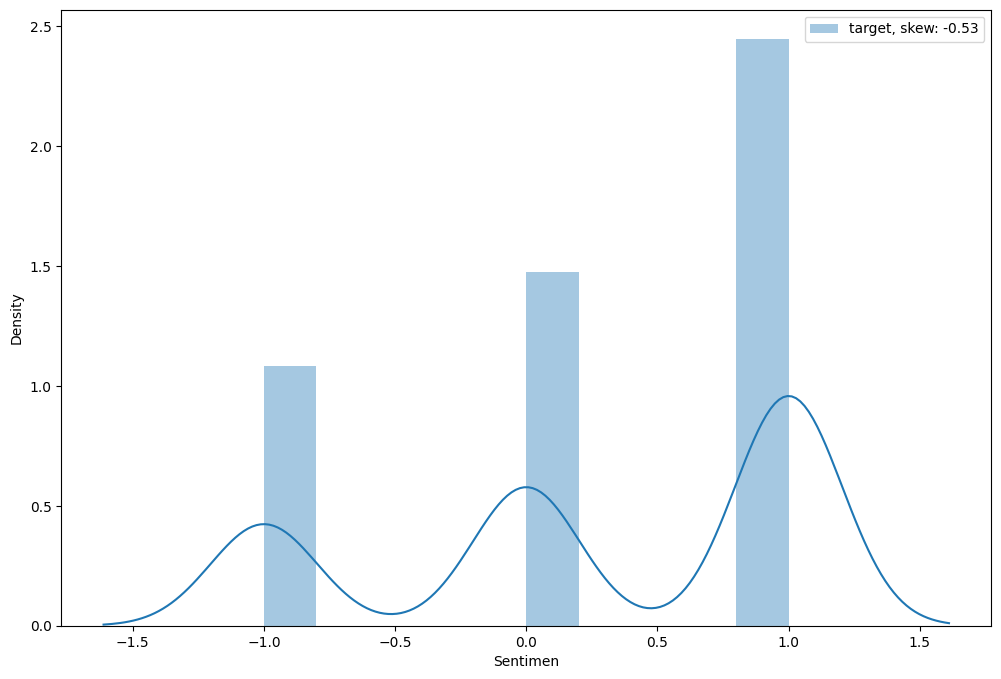

In [46]:
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

In [47]:
dataset_label.value_counts()

Sentimen
 1.0    441
 0.0    266
-1.0    195
Name: count, dtype: int64

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [49]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

In [50]:
test_x

70     selamat ingat jumat agung selamat makna arti k...
235    number narapidana bebas wabah covid number kor...
430    infeksi covid stempel allcaps rfid allcaps dis...
412     tingkat mati rokok covid number kali so repeated
39     sinergitas allcaps tni allcaps allcaps polri a...
                             ...                        
549    pasien positif allcaps covid allcaps number ta...
351    personil polsek karanglewas laksana patroli ma...
720    ketua fraksi golkar allcaps dprd allcaps sumut...
714    cantik number harap impiann kabul impi sembuny...
465    bumi repeated maaf repeated sadar repeated kau...
Name: ProcessedText, Length: 271, dtype: object

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

## Naive Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB

In [53]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [54]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [55]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [56]:
classifier_nb.fit(train_x, train_label.ravel())

C:\Users\annis\AppData\Local\Temp\ipykernel_20668\4039834798.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  classifier_nb.fit(train_x, train_label.ravel())


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [57]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  0.9746434231378764
Accuracy Test set:  0.5867158671586716


In [58]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  0.9746434231378764
Recall Test set:  0.5867158671586716


In [59]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  0.974662325356997
Precision Test set:  0.5590072881261386


In [60]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  0.9746488039222794
F1 Test set:  0.5634971095809093


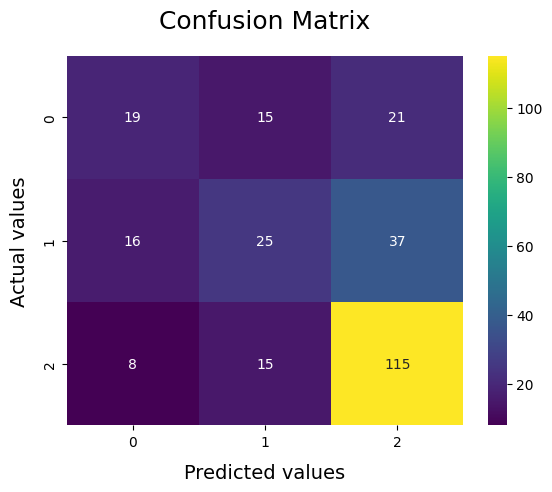

In [61]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [62]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', MultinomialNB(alpha=0.1))])

In [63]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 0.1
tfidf__ngram_range: (1, 1)


## KNN

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
train_x.dtype

dtype('O')

In [66]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_x_encoded = label_encoder.fit_transform(train_x)

In [67]:
test_x_encoded = label_encoder.fit_transform(test_x)

In [68]:
train_x_encoded.dtype

dtype('int32')

In [69]:
train_x_encoded = train_x_encoded.reshape(-1, 1)

In [70]:
test_x_encoded = test_x_encoded.reshape(-1, 1)

In [71]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_x_encoded, train_label)

KNeighborsClassifier(n_neighbors=3)

In [72]:
y_pred_knn_train = model.predict(train_x_encoded)
accuracy_knn_train = accuracy_score(train_label, y_pred_knn_train)
print("Accuracy Training set: ", accuracy_knn_train)

y_pred_knn_test = model.predict(test_x_encoded)
accuracy_knn_test = accuracy_score(test_label, y_pred_knn_test)
print("Accuracy Test set: ", accuracy_knn_test)

Accuracy Training set:  0.6957210776545166
Accuracy Test set:  0.36162361623616235


In [73]:
recall_knn_train = recall_score(train_label, y_pred_knn_train, average='weighted')
print("Recall Training set: ", recall_knn_train)

recall_knn_test = recall_score(test_label, y_pred_knn_test, average='weighted')
print("Recall Test set: ", recall_knn_test)

Recall Training set:  0.6957210776545166
Recall Test set:  0.36162361623616235


In [74]:
precision_knn_train = precision_score(train_label, y_pred_knn_train, average='weighted')
print("Precision Training set: ", precision_knn_train)

precision_knn_test = precision_score(test_label, y_pred_knn_test, average='weighted')
print("Precision Test set: ", precision_knn_test)

Precision Training set:  0.7120759131381655
Precision Test set:  0.3870098119040377


In [75]:
f1_knn_train = f1_score(train_label, y_pred_knn_train, average='weighted')
print("F1 Training set: ", f1_knn_train)

f1_knn_test = f1_score(test_label, y_pred_knn_test, average='weighted')
print("F1 Test set: ", f1_knn_test)

F1 Training set:  0.6969410013158726
F1 Test set:  0.36777675481403427


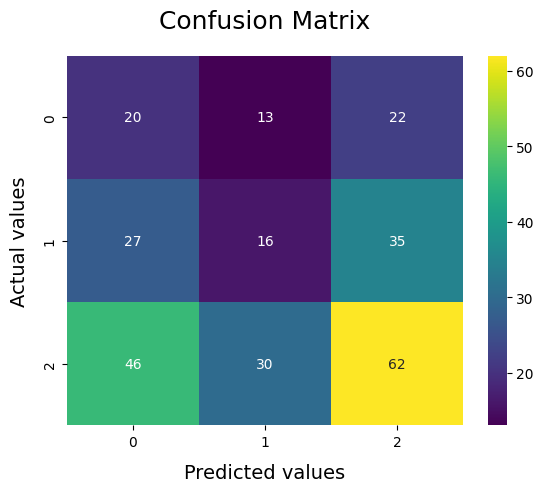

In [76]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_knn_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Visualisasi

In [77]:
models = [        
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
          ('KNN', accuracy_knn_train, accuracy_knn_test),
         ]

In [78]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,0.974643,0.586716
1,KNN,0.695721,0.361624


In [79]:
models_comparison = [                        
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test),
                        ('KNN', accuracy_knn_test, recall_knn_test, precision_knn_test, f1_knn_test),                   
                    ]

In [80]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.586716,0.586716,0.559007,0.563497
1,KNN,0.361624,0.361624,0.387010,0.367777


C:\Users\annis\AppData\Local\Temp\ipykernel_20668\4017775036.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
C:\Users\annis\AppData\Local\Temp\ipykernel_20668\4017775036.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])


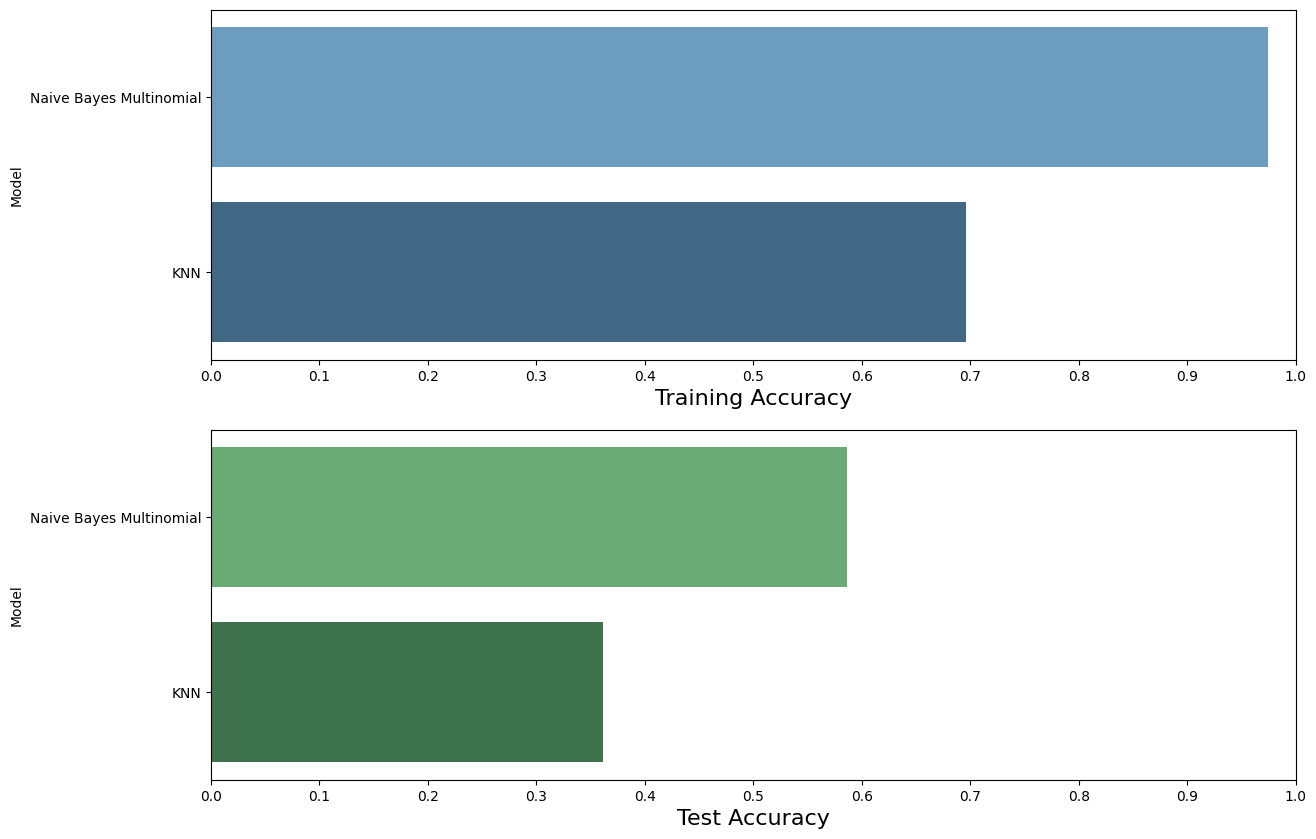

In [81]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

In [82]:
import joblib

In [83]:
# simpan model
joblib.dump(classifier_nb.best_estimator_, 'classifier_nb.best_estimator_.sav', compress=1)

['classifier_nb.best_estimator_.sav']